# Integration of datasets using scVI 
In this notebook, the integration is evaluated before it is used in the script. Evaluation was done using visuals and the Average Silhouette Width (AWS). The closer the AWS to zero the better. 

In [ ]:
# Import libraries
import tarfile
import scanpy as sc
import os
import anndata as ad
import scvi
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# For loop to create an adata for the cancer dataset
# Extract files to a directory
data_dir = "/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/data/raw/cancer"
with tarfile.open("data/raw/cancer/GSE184880_RAW.tar", "r") as tar:
    tar.extractall(path="data/raw/cancer")
# List all prefixes (one per sample)
prefixes = [
    "GSM5599220_Norm1",
    "GSM5599221_Norm2",
    "GSM5599222_Norm3",
    "GSM5599223_Norm4",
    "GSM5599224_Norm5",
    "GSM5599225_Cancer1",
    "GSM5599226_Cancer2",
    "GSM5599227_Cancer3",
    "GSM5599228_Cancer4",
    "GSM5599229_Cancer5",
    "GSM5599230_Cancer6",
    "GSM5599231_Cancer7"
]

adatas = []
for prefix in prefixes:
    # Rename files to match Scanpy's expectations

    os.rename(
        os.path.join(data_dir, f"{prefix}.matrix.mtx.gz"),
        os.path.join(data_dir, f"{prefix}_matrix.mtx.gz")
    )
    os.rename(
        os.path.join(data_dir, f"{prefix}.barcodes.tsv.gz"),
        os.path.join(data_dir, f"{prefix}_barcodes.tsv.gz")
    )
    os.rename(
        os.path.join(data_dir, f"{prefix}.genes.tsv.gz"),
        os.path.join(data_dir, f"{prefix}_features.tsv.gz")
    )
    prefix = prefix + "_" # add underscore 
    adata = sc.read_10x_mtx(
        data_dir,
        prefix=prefix,
        var_names='gene_symbols',
        make_unique=True,
        cache=True
    )
    adata.obs["sample"] = prefix.rstrip("_")
    adatas.append(adata)
# Concatenate all Objects inside adatas into one
adata_cancer = ad.concat(adatas, label="batch", index_unique="-", keys=[p.rstrip("_") for p in prefixes])

In [3]:
# Extract files to a directory
data_dir = "/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/data/raw/endo"
with tarfile.open("data/raw/endo/GSE214411_RAW.tar", "r") as tar:
    tar.extractall(path="data/raw/endo")
# List all prefixes (one per sample)
prefixes = [
    "GSM6605431_EMS1_",
    "GSM6605432_EMS2_",
    "GSM6605433_EMS3_",
    "GSM6605434_EMS4_",
    "GSM6605435_EMS5_",
    "GSM6605436_EMS6_",
    "GSM6605437_N1_",
    "GSM6605438_N2_",
    "GSM6605439_N3_",
    "GSM6605440_N4_",
    "GSM7277296_N-5_",
    "GSM7277297_N-6_",
    "GSM7277298_N-7_"
]

adatas = []
for prefix in prefixes:
    adata = sc.read_10x_mtx(
        data_dir,
        prefix=prefix,
        var_names='gene_symbols',
        make_unique=True,
        cache=True
    )
    adata.obs["sample"] = prefix.rstrip("_")
    adatas.append(adata)
# Concatenate all Objects inside adatas into one
adata_endo = ad.concat(adatas, label="batch", index_unique="-", keys=[p.rstrip("_") for p in prefixes])

In [4]:
def preprocess(adata):
    # Basic filtering
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=3)
    # Annotate mito genes and filter them 
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
    )
    adata = adata[adata.obs.n_genes_by_counts < 2500, :]
    adata = adata[adata.obs.pct_counts_mt < 20, :].copy()
    # Assign a copy
    adata_copy = adata.copy()
    # Normalize
    sc.pp.normalize_total(adata_copy, target_sum=1e4)
    # Logarithmize
    sc.pp.log1p(adata_copy)
    # Identify highly variable genes
    sc.pp.highly_variable_genes(adata_copy, min_mean=0.0125, max_mean=3, min_disp=0.5)
    # Plug the highly variable genes back into the original adata
    adata = adata[:, adata_copy.var.highly_variable]
    return adata

In [41]:
def vis_umap(adata, x):
    sc.pp.neighbors(adata, use_rep="X_scVI")
    sc.tl.umap(adata)
    sc.tl.leiden(
        adata,
        resolution=0.25,
        random_state=0
    )
    return sc.pl.umap(adata, color= x)

In [6]:
# Highly variable genes
adata_cancer = preprocess(adata_cancer)
adata_endo = preprocess(adata_endo)

In [8]:
# Merge the two datasets
adata_merged = ad.concat(
    [adata_endo, adata_cancer],
    axis=0,          # Concatenate along cells 
    join="outer",    # Keep all genes only
    keys=["Endometriosis", "Cancer"],
    merge="unique",  # Handle overlapping metadata uniquely
    index_unique="-",  # Avoid duplicate observation names
    fill_value=0     # Fill missing values wth zeros
)

In [9]:
# Assign datasets as a column
adata_merged.obs['dataset'] = adata_merged.obs.index.str.split('-').str[-1]
# Assign samples as a column
adata_merged.obs['samples'] = adata_merged.obs["sample"].str.split('-').str[0]

In [10]:
# Create target variable in obs
adata_merged.obs["target"] = (
    adata_merged.obs["sample"]
    .str.split("_").str[-1]
    .str[0]
    .map({"C": "Cancer", "E": "EMS", "N": "Normal"})
)

# Extract group and target information from adata.obs
groups = adata_merged.obs['samples']
y = adata_merged.obs['target']

In [85]:
# Create the splitter (n_splits=2 for train/test)
sgkf = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=42)

# Get the first split (train/test indices)
train_idx, test_idx = next(sgkf.split(adata_merged.X, y, groups))

# Subset the AnnData object for train and test
adata_train = adata_merged[train_idx].copy()
adata_test = adata_merged[test_idx].copy()

adata_train.layers["counts"] = adata_train.X
adata_test.layers["counts"] = adata_test.X

In [88]:
adata_train.X

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 8094886 stored elements and shape (66229, 3733)>

In [89]:
adata_test.X

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 2998354 stored elements and shape (22575, 3733)>

In [ ]:
# Check for NaNs
from scipy.sparse import csr_matrix

# If adata.X is your CSR sparse matrix:
matrix = adata_test.X  # or replace with your variable

# Find indices of NaNs in the data array
nan_mask = np.isnan(matrix.data)
nan_indices = np.where(nan_mask)[0]

# Optionally, print the row and column indices of NaNs
if nan_indices.size > 0:
    coo = matrix.tocoo()
    for i in nan_indices:
        print(f"NaN at row {coo.row[i]}, column {coo.col[i]}")
else:
    print("No NaNs found.")

No NaNs found.


# scVI Integration

In [16]:
# Extract group and target information from adata.obs
groups = adata_merged.obs['samples']
y = adata_merged.obs['target']

# Create the splitter (n_splits=2 for train/test)
sgkf = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=42)

# Get the first split (train/test indices)
train_idx, test_idx = next(sgkf.split(adata_merged.X, y, groups))

# Subset the AnnData object for train and test
adata_train = adata_merged[train_idx].copy()
adata_test = adata_merged[test_idx].copy()

### Are splits stratified as needed? They should have cells from all datasets and targets

In [17]:
adata_train.obs["samples"].nunique()

18

In [19]:
adata_train.obs["dataset"].unique()

array(['Endometriosis', 'Cancer'], dtype=object)

In [20]:
adata_train.obs["target"].unique()

array(['EMS', 'Normal', 'Cancer'], dtype=object)

In [22]:
adata_test.obs["samples"].nunique()

7

In [23]:
adata_test.obs["dataset"].unique()

array(['Endometriosis', 'Cancer'], dtype=object)

In [24]:
adata_test.obs["target"].unique()

array(['EMS', 'Normal', 'Cancer'], dtype=object)

In [ ]:
# Assign counts to layers
adata_train.layers["counts"] = adata_train.X
adata_test.layers["counts"] = adata_test.X

Integration process of both datasets

In [28]:
# Integration of train data

# Setup model, fit, and normalise train dataset 
scvi.model.SCVI.setup_anndata(adata_train, layer="counts", 
                              categorical_covariate_keys= ["sample", "dataset"], # choosing datasets as a covariate
                              continuous_covariate_keys= ["pct_counts_mt", "total_counts"])
# Fit on train set only
model = scvi.model.SCVI(adata_train, n_layers=2, n_latent=30, gene_likelihood="nb")
model.train(accelerator="gpu") 

# Get normalized counts for train set
norm_train = model.get_normalized_expression(
    adata_train, 
    library_size=1e4,
    return_numpy=False
)
# Insert integrated data to Anndata
latent_train = model.get_latent_representation()
adata_train.obsm["X_scVI"] = latent_train
normalized_train = model.get_normalized_expression(library_size=le4)
adata_train.layers["scVI_normalized"] = normalized_train

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been set to `mps`. Please note that not all PyTorch/Jax operations are supported with this backend. as a result, some models might be slower and less accurate than usuall. Please verify your analysis!Refer to https://github.com/pytorch/pytorch/issues/77764 for more details.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 121/121: 100%|██████████| 121/121 [21:18<00:00, 10.49s/it, v_num=1, train_loss_step=458, train_loss_epoch=411]

`Trainer.fit` stopped: `max_epochs=121` reached.


Epoch 121/121: 100%|██████████| 121/121 [21:18<00:00, 10.57s/it, v_num=1, train_loss_step=458, train_loss_epoch=411]


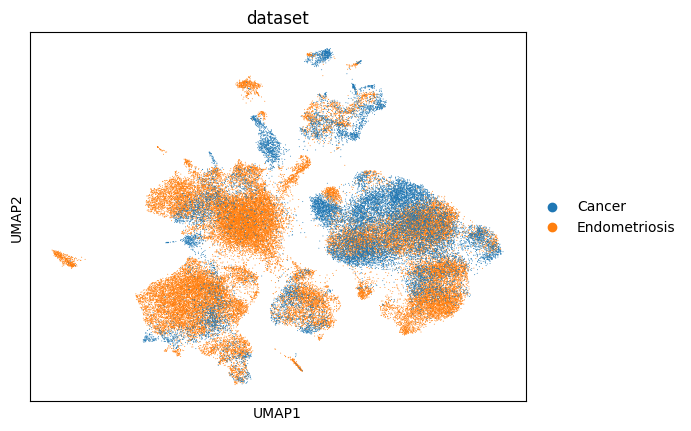

In [42]:
# Visualize UMAP of integrated train data
vis_umap(adata_train, x= "dataset")

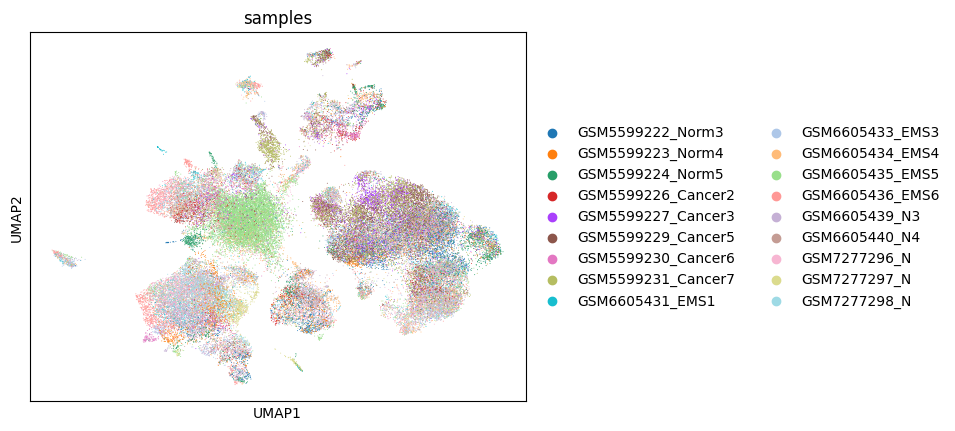

In [60]:
# Visualize UMAP of integrated train data
sc.pl.umap(adata_train, color= ["samples"])

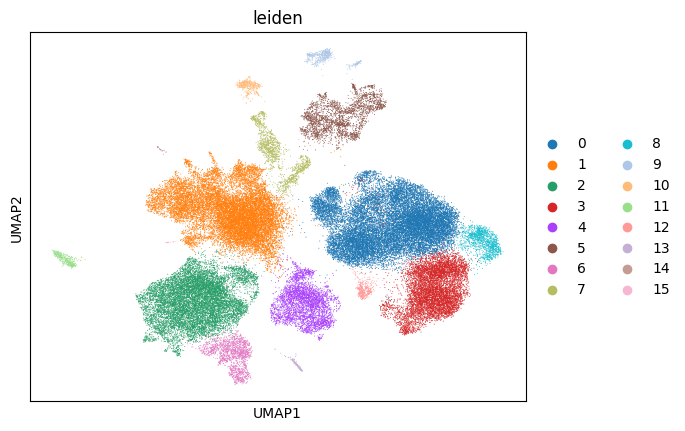

In [59]:
# Visualize UMAP of integrated train data
sc.pl.umap(adata_train, color= ["leiden"])

In [45]:
from matplotlib.pyplot import rc_context

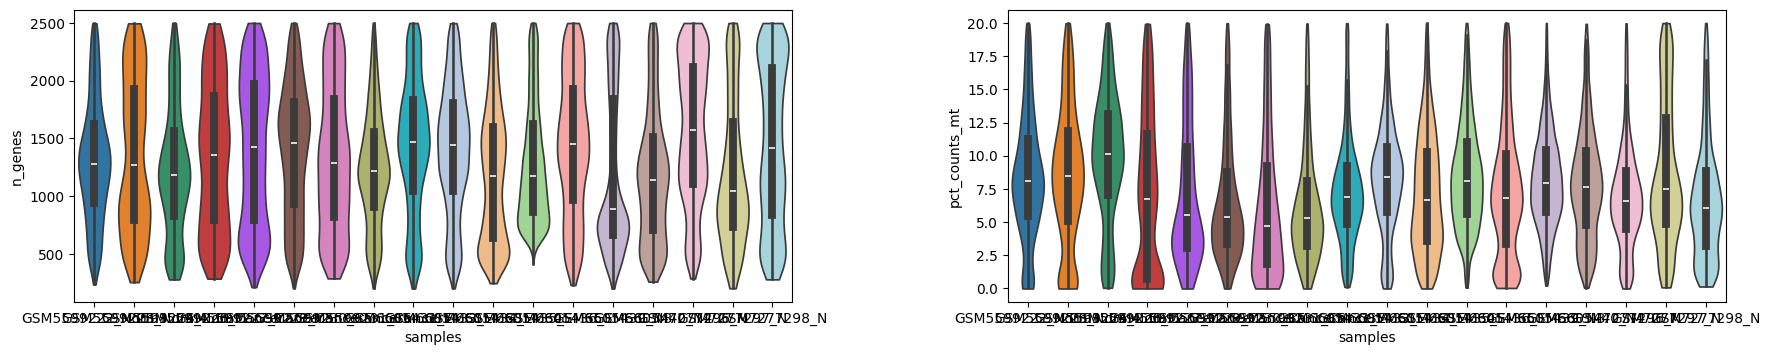

In [ ]:
# EMS5 sample is suspicious but no apparent low quality
with rc_context({"figure.figsize": (8, 4)}):
    sc.pl.violin(
        adata_train,
        ["n_genes", "pct_counts_mt"],
        groupby="samples",
        stripplot=False,  # remove the internal dots
        inner="box",  # adds a boxplot inside violins
    )

In [70]:
# AWS (Average Silhouette Width) for train set, the closer to 0 the better
# Get the embedding (e.g., UMAP, PCA, or integration output)
X_emb = adata_train.obsm['X_scVI']  # or 'X_pca', 'X_integrated', etc.

# Calculate silhouette score for batches (lower is better for batch removal)
asw_batch = silhouette_score(X_emb, adata_train.obs['dataset'])
print("ASW (Train):", asw_batch)

ASW (Train): 0.029534921


In [54]:
# Setup model, fit, and normalise test dataset 
scvi.model.SCVI.setup_anndata(adata_test, layer="counts", 
                              categorical_covariate_keys= ["sample", "dataset"], # choosing datasets as a covariate
                              continuous_covariate_keys= ["pct_counts_mt", "total_counts"])
# Fit on train set only
model = scvi.model.SCVI(adata_test, n_layers=2, n_latent=30, gene_likelihood="nb")

model.train(accelerator="gpu") 


# Get normalized counts for train set
norm_test = model.get_normalized_expression(
    adata_test,
    library_size=1e4, 
    return_numpy=False
)
# Insert integrated data to Anndata
latent_test = model.get_latent_representation()
adata_test.obsm["X_scVI"] = latent_test

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been set to `mps`. Please note that not all PyTorch/Jax operations are supported with this backend. as a result, some models might be slower and less accurate than usuall. Please verify your analysis!Refer to https://github.com/pytorch/pytorch/issues/77764 for more details.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 354/354: 100%|██████████| 354/354 [20:39<00:00,  3.47s/it, v_num=1, train_loss_step=415, train_loss_epoch=441]

`Trainer.fit` stopped: `max_epochs=354` reached.


Epoch 354/354: 100%|██████████| 354/354 [20:39<00:00,  3.50s/it, v_num=1, train_loss_step=415, train_loss_epoch=441]


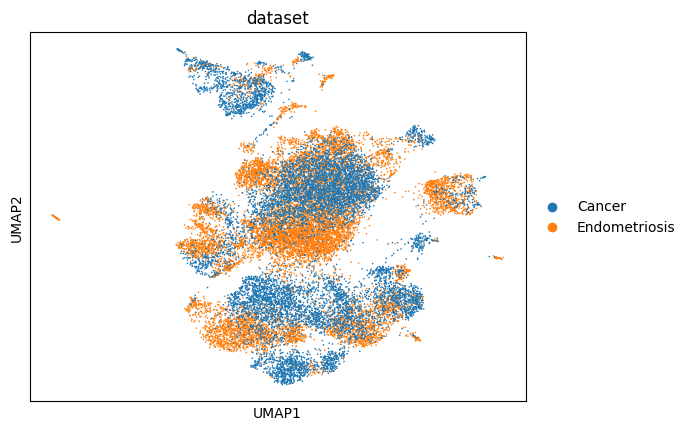

In [ ]:
# Visualize UMAP of integrated test data
vis_umap(adata_test, x= "dataset")

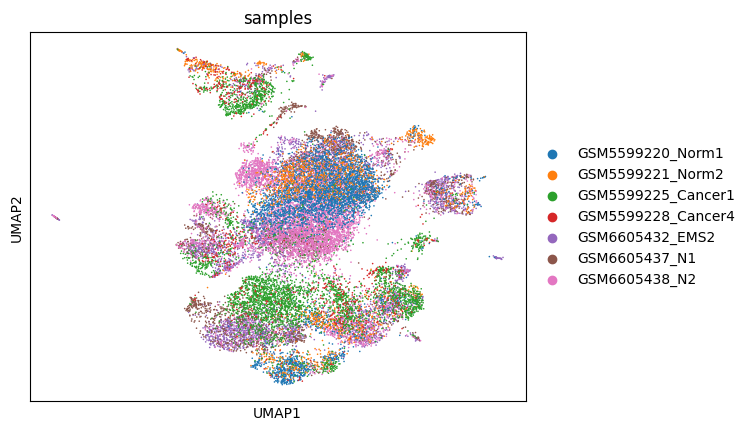

In [56]:
# Visualize UMAP of integrated train data
sc.pl.umap(adata_test, color= ["samples"])

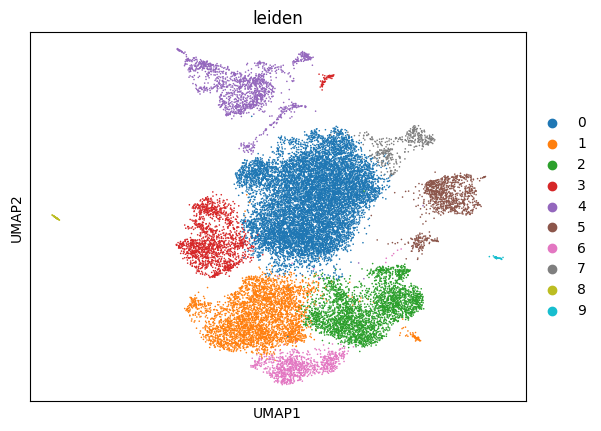

In [58]:
# Visualize UMAP of integrated train data
sc.pl.umap(adata_test, color= ["leiden"])

In [72]:
# AWS (Average Silhouette Width) for train set, the closer to 0 the better
# Get the embedding (e.g., UMAP, PCA, or integration output)
X_emb = adata_test.obsm['X_scVI']  # or 'X_pca', 'X_integrated', etc.

# Calculate silhouette score for batches (lower is better for batch removal)
asw_batch = silhouette_score(X_emb, adata_test.obs['dataset'])
print("ASW (Test):", asw_batch)

ASW (Test): 0.010378595
